In [13]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Download historical data for Apple
data = yf.download('AAPL', start='2020-01-01', end='2025-09-01', interval='1d', auto_adjust=True)

data.head(5)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538528,72.598907,71.292319,71.545905,135480400
2020-01-03,71.833290,72.594055,71.608685,71.765667,146322800
2020-01-06,72.405670,72.444313,70.703005,70.954181,118387200
2020-01-07,72.065140,72.671333,71.845362,72.415330,108872000
2020-01-08,73.224403,73.526295,71.768079,71.768079,132079200


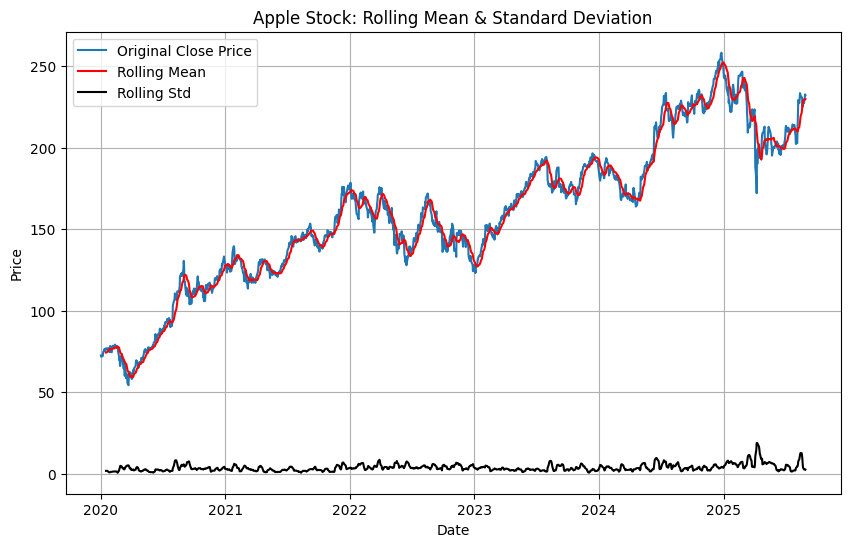

In [3]:
# Example time series data
close = data['Close'] # Using closing prices

# Calculate rolling statistics
rolling_mean = close.rolling(window=12).mean()
rolling_std = close.rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(10,6))
plt.plot(close, label='Original Close Price')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.legend(loc='best')
plt.title('Apple Stock: Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## Apple Stock: Rolling Mean & Standard Deviation (2020–2025)

**Chart Description:**
- **Blue Line (Original Time Series):**  
  Daily closing prices for Apple stock from 2020 to 2025.  
  The jagged movements reflect day-to-day market fluctuations, with visible dips in early 2020 (pandemic) and sharp volatility spikes in 2022 and 2025.  

- **Red Line (Rolling Mean, 12-Day Window):**  
  A smoothed trend line showing the average price over the past 12 days at each point.  
  This makes it easier to observe **overall upward trends** and **medium-term corrections** without being distracted by daily noise.  

- **Black Line (Rolling Standard Deviation, 12-Day Window):**  
  Represents the volatility (price variability) over the last 12 days.  
  Flat areas indicate calm market conditions, while spikes signal periods of heightened activity or news-driven events.  
  Significant volatility spikes appear around early 2020 and mid-2025.  

**Key Insights:**
- Apple stock shows a strong **long-term upward trend** with intermittent dips.  
- Volatility tends to surge during major market events, then settle.  
- Rolling averages help clarify trends and momentum, while rolling standard deviation highlights **market uncertainty**.

**Next Steps:**
- Try a larger window (e.g., `window=50`) for long-term trend smoothing.
- Add **Bollinger Bands** (rolling mean ± 2×std) to visualize price ranges.
- Perform **time series decomposition** to separate trend, seasonality, and residual noise.


In [21]:
# To Decompose the time series, we need a datetime index

# Make sure the index is a proper datetime index
close.index = pd.to_datetime(close.index)

# Resample to monthly data (optional for smoother seasonality)
monthly_close = close.resample('ME').mean()

# Decompose the time series
decomposition = seasonal_decompose(monthly_close, model='additive', period=12)

In [24]:
# Plot the decomposition
# plt.rcParams.update({'figure.figsize': (12, 8)})
# decomposition.plot()
# plt.suptitle('Apple Stock Price Decomposition (Additive Model)', fontsize=16)
# plt.show()

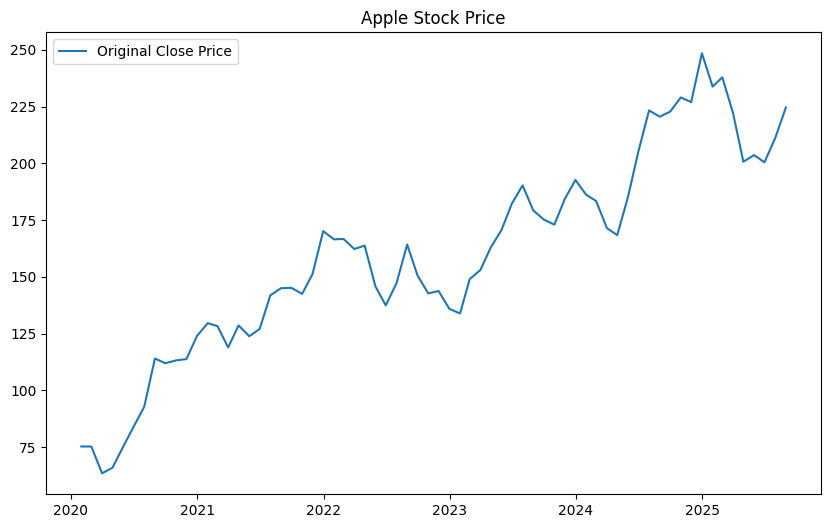

In [23]:
# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(monthly_close, label='Original Close Price')
plt.title('Apple Stock Price')
plt.legend()
plt.show()

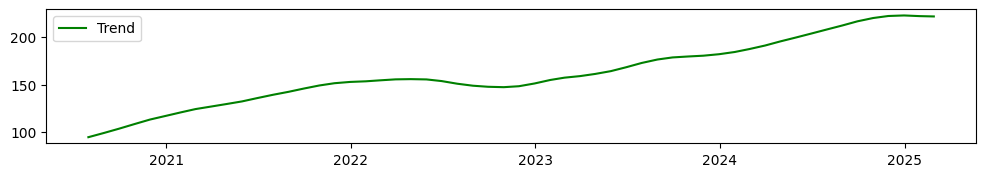

In [25]:
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='upper left')

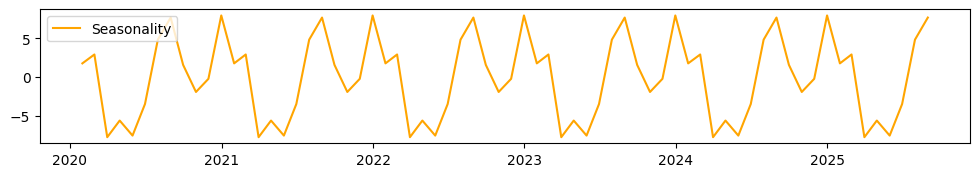

In [26]:
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
plt.legend(loc='upper left')

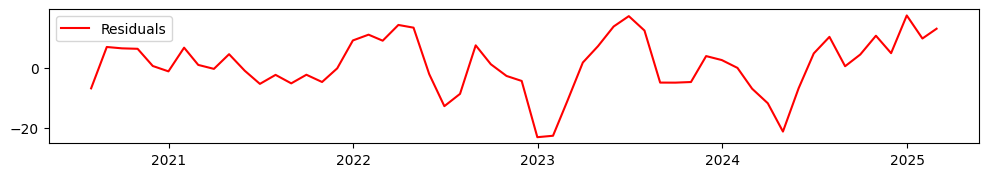

In [27]:
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='upper left')